In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

NumberOfPhases = 3
#Read the labeled training set
#The phases are skyrmions, ferromagnetic and spin spirals
#Labels: skyrmions--0; ferromagnetic--1, spin spirals--2
Skyrmions = pd.read_csv("/users/PAS1495/gsdbuilder/FinalProject/Model/SelectedPhases/Skyrmions_z.csv")
Ferromagnetics = pd.read_csv("/users/PAS1495/gsdbuilder/FinalProject/Model/SelectedPhases/Ferrogmanetic_z.csv")
Spirals = pd.read_csv("/users/PAS1495/gsdbuilder/FinalProject/Model/SelectedPhases/Spiral_z.csv")

#For a file will all the data, xspin is 0~783, yspin is 784~1567, zspin is 1568~2351,
#Correspondingly, iloc[:, 0:784], iloc[:, 784:1568], iloc[:, 1568:2352]
#For now, we will use the zspin first. A smaller file is used and the zspin is now 0~783.
file = pd.DataFrame()
file = pd.concat([file, Skyrmions])
file = pd.concat([file, Ferromagnetics])
file = pd.concat([file, Spirals])

#Add the average zspin to the end of the array.
data_dimz = file.iloc[:, 0:784].values
print(data_dimz.shape)

#The label of the data is the column #2356
data_labels = file.iloc[:, 789].values
data_labels_onehot = np.zeros((len(data_labels), NumberOfPhases))
for i in range(len(data_labels)):
    data_labels_onehot[i][data_labels[i]] = 1
    
size = len(data_dimz)
print("The total size of dataset is ", size)
print("We will now select random 80% of the data as train data, and the rest serves as test data")

(4395, 784)
The total size of dataset is  4395
We will now select random 80% of the data as train data, and the rest serves as test data


In [3]:
#Shuffle the data before we choose our train/test dataset.
new_order = np.random.permutation(range(size))
train_range = new_order[0:int(0.8*size)] #The training sample is 80% of the total dataset.
test_range = new_order[int(0.8*size):size]

NumberOfPhases = 3
x_train = data_dimz[train_range]
y_train_onehot = data_labels_onehot[train_range]

x_test = data_dimz[test_range]
y_test_onehot = data_labels_onehot[test_range]

print("The training and testing sample sizes are ")
print(len(train_range), len(test_range))

print("The shape of the training and test samples:\n", x_train.shape, x_test.shape)

The training and testing sample sizes are 
3516 879
The shape of the training and test samples:
 (3516, 784) (879, 784)


Define the Variational Autoencoder and see if it can recognize the pattern in the images and create a parameter space.

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras import metrics

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments     args (tensor): mean and log of variance of Q(z|X)
    # Returns       z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

Using TensorFlow backend.


In the class example, the VAE uses a dense layer. However, we can use a convolutional layer.

In [14]:
# network parameters
original_dim = 784
input_shape = (784, )
batch_size = 256
latent_dim = 200
intermediate_dim = 400
epochs = 100

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
# The input layer is connectted to the latent vector layer via 1 convolutional layer to each of the mean and var layers.

# Take the outout of the first dense layer and send this output into
# *two* *separate* layers
# The out of these layers are the mean and sigma vectors for our latent vector x
#   ===> Note we actually use the log(sigma) rather than sigma - this prevents sigma from 
#        going negative and make the model more stable
z_mean = Dense(latent_dim, name='z_mean')(inputs)
z_log_var = Dense(latent_dim, name='z_log_var')(inputs)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
# This "trick" is needed to make backpropagation work when you have a 
# stochastic effect (the sampling of the sigma part of the z vector)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# The "encoder" is everything from the input layer to the combined mean, sigma, and sampled z vectors
encoder = Model(inputs=inputs, outputs=[z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)


# build decoder model
# This does not actually specify the input - "latent_inputs" is just a placeholder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
#
# The decoder has one intermediate layer of 400 parameters.
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x) #The "output" variable will soon be assigned to other things.
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
# ==> This next line defines the output as the output of the decoder (of course)
# ==> The input to the decoder is the *third* output of the encoder ==> the z vector
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# We need to specify a "custom" loss, since we need both the reconstruction loss *AND* the KL loss
# Setup two possible choices for the recon loss
msa = False
if mse:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs, outputs)
    
# Scale by the input size - this is to keep it on the same scale
# as the KL loss
reconstruction_loss *= original_dim

# Now define the KL loss
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

# USe a function to supply the loss we will give the fit method
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(inputs,outputs)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

# Now compile our model!
vae.compile(optimizer='adam',loss=vae_loss)
print("summary")
print(vae.summary())
plot_model(vae, to_file='vae_mlp.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 200)          157000      encoder_input[0][0]              
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 200)          157000      encoder_input[0][0]              
__________________________________________________________________________________________________
z (Lambda)                      (None, 200)          0           z_mean[0][0]                     
                                                                 z_log_var[0][0]                  
Total para

Fit the Variational Autoencoder and save the model

In [15]:
#Fit the VAE
history = vae.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, x_test))

encoder.save('fully_trained_encoder.h5')

Train on 3516 samples, validate on 879 samples
Epoch 1/100
3516/3516 [==============================] - 3s 990us/step - loss: 589.5282 - val_loss: 455.3451
Epoch 2/100
3516/3516 [==============================] - 2s 579us/step - loss: 378.8679 - val_loss: 333.3757
Epoch 3/100
3516/3516 [==============================] - 2s 579us/step - loss: 290.5655 - val_loss: 288.5083
Epoch 4/100
3516/3516 [==============================] - 2s 579us/step - loss: 271.0323 - val_loss: 283.3290
Epoch 5/100
3516/3516 [==============================] - 2s 579us/step - loss: 254.5830 - val_loss: 264.3165
Epoch 6/100
3516/3516 [==============================] - 2s 585us/step - loss: 241.7461 - val_loss: 255.7781
Epoch 7/100
3516/3516 [==============================] - 2s 581us/step - loss: 230.9588 - val_loss: 248.7369
Epoch 8/100
3516/3516 [==============================] - 2s 584us/step - loss: 218.1572 - val_loss: 232.4383
Epoch 9/100
3516/3516 [==============================] - 2s 578us/step - loss: 20

decoded_imgs.shape (3516, 784)


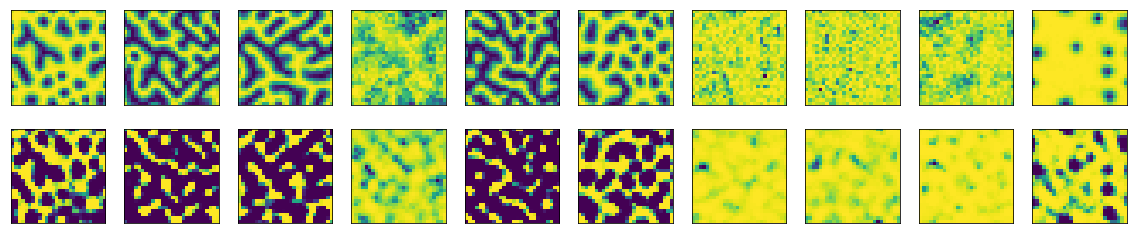

In [11]:
decoded_imgs = vae.predict(x_train)
print("decoded_imgs.shape",decoded_imgs.shape)

import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i+10].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i+10].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

plt.show()

In [12]:
for layer in encoder.layers:
    layer.trainable = False
    print(layer, "trainable? ", layer.trainable)
    

intermediate_dim = 64

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
#
# This is an intermediate layer for the decoder
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
#
# The output layer has sigmoid activation (just like our normal autoencoder)
# and the same dimension as our input
outputs = Dense(NumberOfPhases, activation='sigmoid')(x)

# instantiate decoder model
fcn = Model(latent_inputs, outputs, name='decoder')
fcn.summary()
plot_model(fcn, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
# ==> This next line defines the output as the output of the decoder (of course)
# ==> The input to the decoder is the *third* output of the encoder ==> the z vector
#The mean and variance output is not used here.
outputs = fcn(encoder(inputs)[2])
stacked = Model(inputs, outputs, name='vae_mlp')

# Now compile our model!
stacked.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("summary")
print(stacked.summary())
plot_model(stacked, to_file='vae_mlp.png', show_shapes=True)

<keras.engine.input_layer.InputLayer object at 0x2b15518c3358> trainable?  False
<keras.layers.core.Dense object at 0x2b15518c3390> trainable?  False
<keras.layers.core.Dense object at 0x2b15518c9cc0> trainable?  False
<keras.layers.core.Lambda object at 0x2b1552adc0f0> trainable?  False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 150)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                9664      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 195       
Total params: 9,859
Trainable params: 9,859
Non-trainable params: 0
_________________________________________________________________
summary
_________________________________________________________________
Layer (type)                 Output Shape

In [13]:
epochs = 50
batch_size = 256
history = stacked.fit(x_train, y_train_onehot, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test_onehot))

Train on 3516 samples, validate on 879 samples
Epoch 1/50
3516/3516 [==============================] - 1s 155us/step - loss: 1.1357 - acc: 0.4784 - val_loss: 0.8951 - val_acc: 0.5597
Epoch 2/50
3516/3516 [==============================] - 0s 43us/step - loss: 0.7379 - acc: 0.6738 - val_loss: 0.6812 - val_acc: 0.6985
Epoch 3/50
3516/3516 [==============================] - 0s 43us/step - loss: 0.5989 - acc: 0.7514 - val_loss: 0.5781 - val_acc: 0.7588
Epoch 4/50
3516/3516 [==============================] - 0s 44us/step - loss: 0.5083 - acc: 0.8003 - val_loss: 0.5146 - val_acc: 0.7816
Epoch 5/50
3516/3516 [==============================] - 0s 43us/step - loss: 0.4503 - acc: 0.8211 - val_loss: 0.4535 - val_acc: 0.8180
Epoch 6/50
3516/3516 [==============================] - 0s 44us/step - loss: 0.3849 - acc: 0.8461 - val_loss: 0.3960 - val_acc: 0.8510
Epoch 7/50
3516/3516 [==============================] - 0s 43us/step - loss: 0.3430 - acc: 0.8658 - val_loss: 0.3597 - val_acc: 0.8692
Epoch 8

In [ ]:
Compared with multiheaded convolutional neural network,